In [1]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from more_itertools import windowed
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tqdm import tqdm

from src.data.loaders.ascad import ASCAD_DATA
from src.data.traceloader import AscadRandomKey
from src.dlla.hw import dlla_hw, prepare_traces
from src.tools.cache import cache_np, cache_pkl
from src.tools.lists import moving_average

In [2]:
RAW = h5py.File(f"/data/ASCAD/ATMEGA_AES_v1/ASCAD_data/ASCAD_databases/atmega8515-raw-traces.h5", 'r')

clip = AscadRandomKey().default.profile.traces

In [3]:
list(RAW['metadata'][1])

[array([235, 191,  17, 131, 222,  95, 192, 198, 214, 118,  80, 139, 179,
        129, 115,  25], dtype=uint8),
 array([ 39, 156,  77,  76, 135,   0,  24, 181, 160, 122,   0,  94,  86,
         95, 172,  39], dtype=uint8),
 array([  0,   0, 160,   9, 190, 240, 118, 153, 129,  87, 113, 255, 180,
        171, 182, 117, 115, 150], dtype=uint8)]

In [4]:
trace = RAW['traces'][0]

np.arange(0, len(trace), 700).shape

(358,)

In [5]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.set_style('whitegrid')

In [6]:
def find(a, b):
    return [x for x in range(len(a)) if np.all(a[x:x+len(b)] == b)]

# find(trace, clip[0])
IX_CLIP = 80945

In [7]:
RAW['hamming_weights'][0]

array([[4, 3, 6, 5, 2, 3, 7, 7, 4, 4, 5, 5, 5, 4, 4, 3],
       [6, 6, 2, 5, 5, 4, 3, 4, 2, 6, 3, 4, 6, 4, 4, 7],
       [4, 6, 2, 4, 2, 3, 1, 6, 4, 4, 5, 3, 4, 5, 5, 5],
       [4, 7, 2, 3, 6, 5, 4, 1, 5, 0, 2, 4, 4, 4, 4, 4],
       [3, 5, 3, 5, 4, 5, 3, 4, 3, 6, 4, 5, 2, 7, 4, 5],
       [2, 2, 3, 3, 5, 4, 5, 3, 5, 6, 4, 2, 5, 4, 5, 7],
       [4, 5, 4, 6, 5, 4, 5, 5, 4, 5, 2, 6, 2, 6, 3, 4],
       [6, 6, 4, 3, 0, 2, 6, 6, 8, 5, 5, 3, 5, 5, 3, 2],
       [4, 4, 2, 5, 7, 3, 4, 5, 3, 5, 2, 4, 2, 5, 4, 2],
       [4, 2, 4, 5, 4, 6, 3, 4, 4, 5, 4, 7, 4, 2, 2, 2]], dtype=uint8)

In [8]:
TARGET_BYTE = 2
TARGET_ROUND = 0

Y = RAW['hamming_weights'][:, TARGET_ROUND, TARGET_BYTE]
X = RAW['traces']

In [9]:
TRACE_LEN = 1400
STEP = 700
NUM_CLASSES = 9
WINDOWS = np.array(list(windowed(range(len(X)), n=TRACE_LEN, step=STEP)))[:-1]

In [10]:
def make_mlp(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(100, activation=params['activation'], input_shape=(1400,)))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(100, activation=params['activation']))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=True)

    return out, mdl

def get_best_model(args):
    return make_mlp(*args, params={
        'activation':'relu',
        'optimizer': Adam(lr=0.001),
        'losses': 'categorical_crossentropy',
        'batch_size': 150,
        'epochs': 5
    })[1]

In [11]:
SLIDING_RES = {}

In [12]:
def make_mlp_quick(x, y, x_attack, y_attack, params):
    mdl = Sequential()
    mdl.add(Dense(25, activation=params['activation'], input_shape=(1400,)))
    mdl.add(Dense(NUM_CLASSES, activation='softmax'))

    mdl.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=params['batch_size'],
                  epochs=params['epochs'], verbose=True)

    return out, mdl

def get_quick_model(args):
    return make_mlp_quick(*args, params={
        'activation':'relu',
        'optimizer': Adam(lr=0.001),
        'losses': 'categorical_crossentropy',
        'batch_size': 150,
        'epochs': 1
    })[1]

ATTACK_SIZE = 50000

def sliding_model(make_model=get_best_model):
    segments = h5py.File(f"{ASCAD_DATA}/ASCAD_data/ASCAD_databases/raw-segments.h5", 'r')

    selection_profile = np.random.random(len(X)) > ATTACK_SIZE / len(X)

    ix_profile = np.where(selection_profile)
    ix_attack = np.where(np.invert(selection_profile))

    res = SLIDING_RES
    for window_ix in tqdm(range(100, 130)):
        if window_ix in res:
            continue

        x = np.array(segments[str(window_ix)])
        y = Y.copy()

        profile = x[ix_profile], y[ix_profile]
        attack = x[ix_attack], y[ix_attack]
        x_prof, y_prof, x_att, y_att = prepare_traces(profile, attack)

        mdl = make_model((x_prof, y_prof, x_att, y_att))
        res[window_ix] = dlla_hw(mdl, x_att, y_att), mdl.get_weights()

    return res

SLIDING_RES = cache_pkl("quick_mlp", sliding_model, get_quick_model, v=1, replace=False)

[(k, SLIDING_RES[k][0]) for k in SLIDING_RES]

[(100, (0.49913200058053364, 0.38923726124161406)),
 (101, (0.9889156173019872, 0.8549033543459743)),
 (102, (0.2588894039605462, 0.17924999608971579)),
 (103, (0.233073192699575, 0.4243701445250241)),
 (104, (0.3689118276543476, 0.6362967282831984)),
 (105, (0.5564866365471213, 0.619257280895332)),
 (106, (0.12066037576278289, 0.1926208413977081)),
 (107, (0.11805251012324824, 0.28412459863083817)),
 (108, (0.840409910659174, 0.8206412196172176)),
 (109, (0.5062598651720909, 0.9244000644193262)),
 (110, (0.022983278856373576, 0.44623237006433614)),
 (111, (0.8879331701032942, 0.5130601314340911)),
 (112, (0.7010414144043272, 0.10540961811447083)),
 (113, (0.5059407934219111, 0.6490323128496808)),
 (114, (0.8165811395208633, 0.8029448741047561)),
 (115, (0.3056706401560626, 0.29888655382187324)),
 (116, (0.0890055447099849, 0.10861264268396927)),
 (117, (0.2572324659003406, 0.09162134546811379)),
 (118, (1.8575256780516085e-05, 0.8108526114950266)),
 (119, (2.0041044915229367e-294, 0.2

In [19]:
def extract_pvs(sliding_res: dict):
    win_ixs = np.ceil(WINDOWS.mean(axis=1))
    a = np.array([(win_ixs[k], *sliding_res[k][0]) for k in sliding_res])

    return a[a[:,0].argsort()]

def plot_sliding_model(sliding_res: dict, mark_clip=True):
    sliding_pvs = extract_pvs(sliding_res)
    ix = sliding_pvs[:, 0]
    pvs = sliding_pvs[:, 1:]

    df = pd.DataFrame(pvs, columns=["A vs. B", "A vs. A"], index=ix)

    fig, ax = plt.subplots()
    g = sns.lineplot(data=df)
    g.set(yscale="log", xlabel="Sample point index", ylabel="min $p$-value",
               title=f"Minimal MLP predictions.\nTraining set size: {len(X) - ATTACK_SIZE - 1} traces. Attack set size: {ATTACK_SIZE} traces\n A: $HW < 4$. B: $HW > 4$\n")
    g.invert_yaxis()

    if mark_clip:
        highlight = sns.color_palette()[3]

        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpatches.Patch(facecolor=highlight, alpha=.2))
        labels.append("Selected by ASCAD")

        ax.legend(handles=handles, labels=labels)

        ax.axvspan(IX_CLIP, IX_CLIP+1400, alpha=.1, color=highlight)
        plt.show()

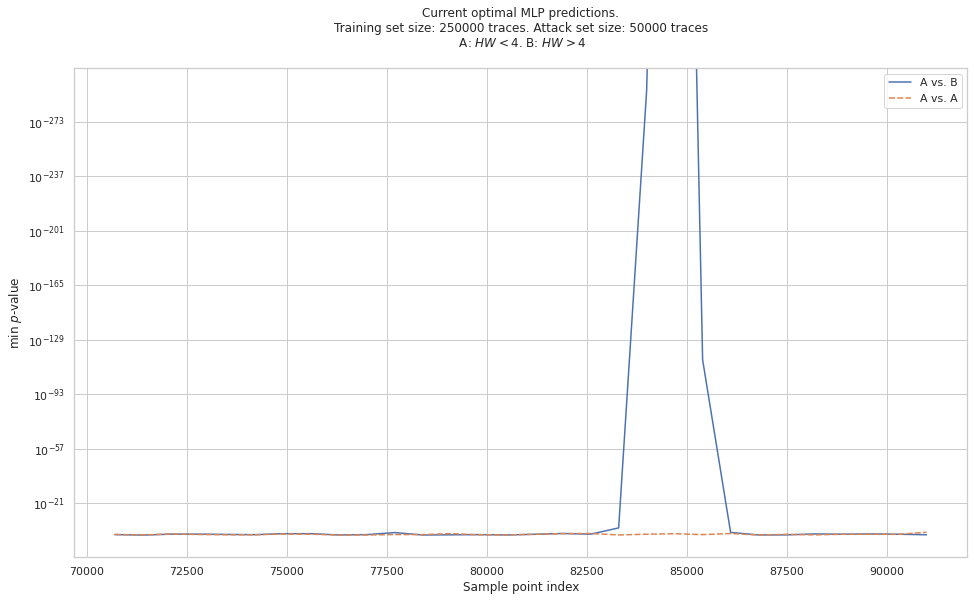

In [14]:
plot_sliding_model(SLIDING_RES, False)

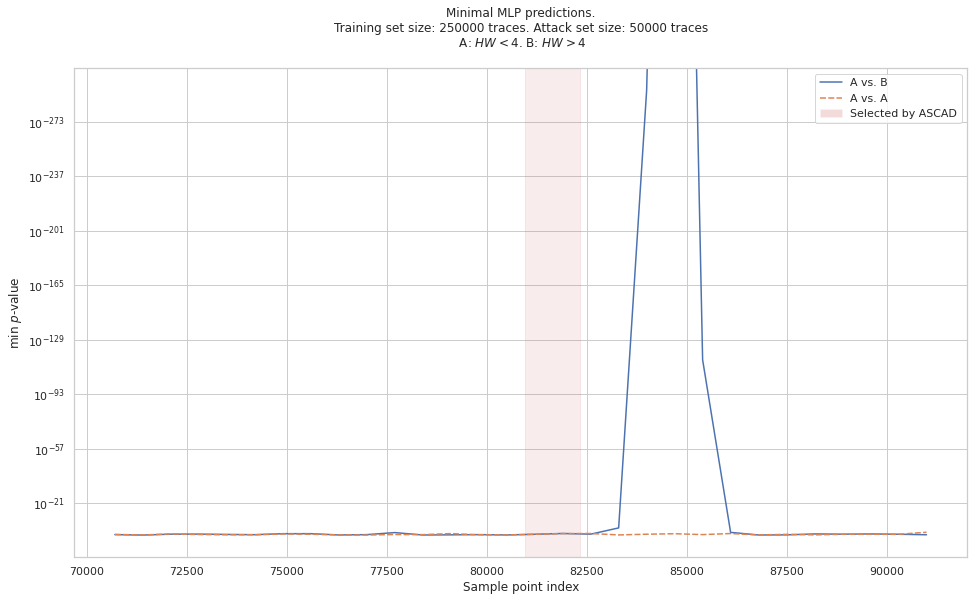

In [20]:
plot_sliding_model(SLIDING_RES)

In [16]:
WINDOWS[114]

array([79800, 79801, 79802, ..., 81197, 81198, 81199], dtype=object)

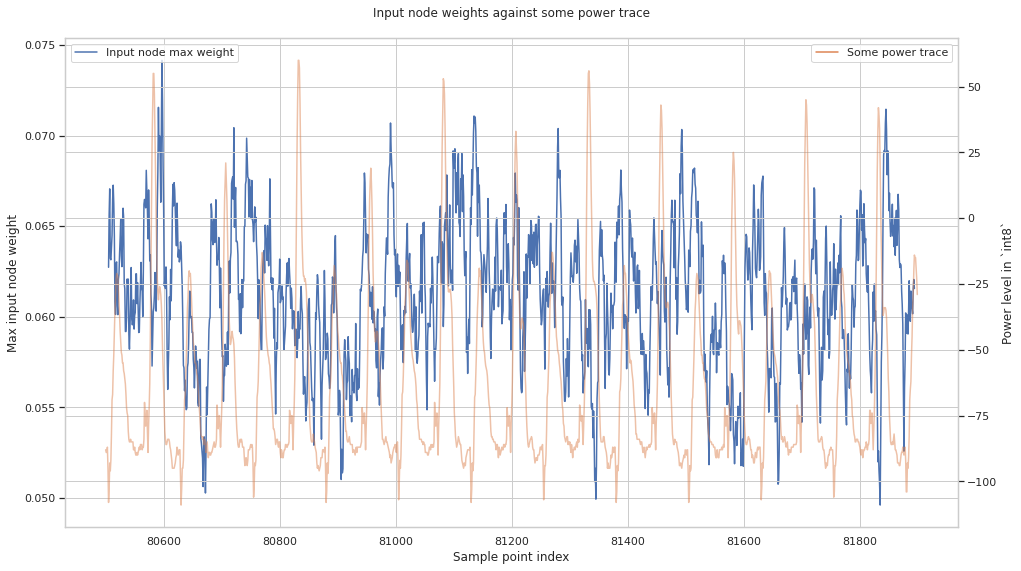

In [17]:
def plot_input_weight(sliding_res: dict, subject=119, moving_average_window=10):
    input_weights = sliding_res[subject][1][0].max(axis=1)
    ix = WINDOWS[subject]

    _, ax = plt.subplots()

    ma_max_weight = moving_average(input_weights, moving_average_window)
    g = sns.lineplot(data=pd.DataFrame({"Input node max weight": ma_max_weight}, index=ix))
    g.set(title="Input node weights against some power trace\n", xlabel="Sample point index", ylabel="Max input node weight")

    ax2 = plt.twinx()
    ax2.set(ylabel="Power level in `int8`")

    power_trace = np.array(X[0])[WINDOWS[119].astype(int)]
    g2 = sns.lineplot(data=pd.DataFrame({"Some power trace": power_trace}, index=ix), palette=[sns.color_palette()[1]], alpha=.5)

    ax.legend(loc="upper left")
    ax2.legend(loc="upper right")

plot_input_weight(SLIDING_RES, 115)

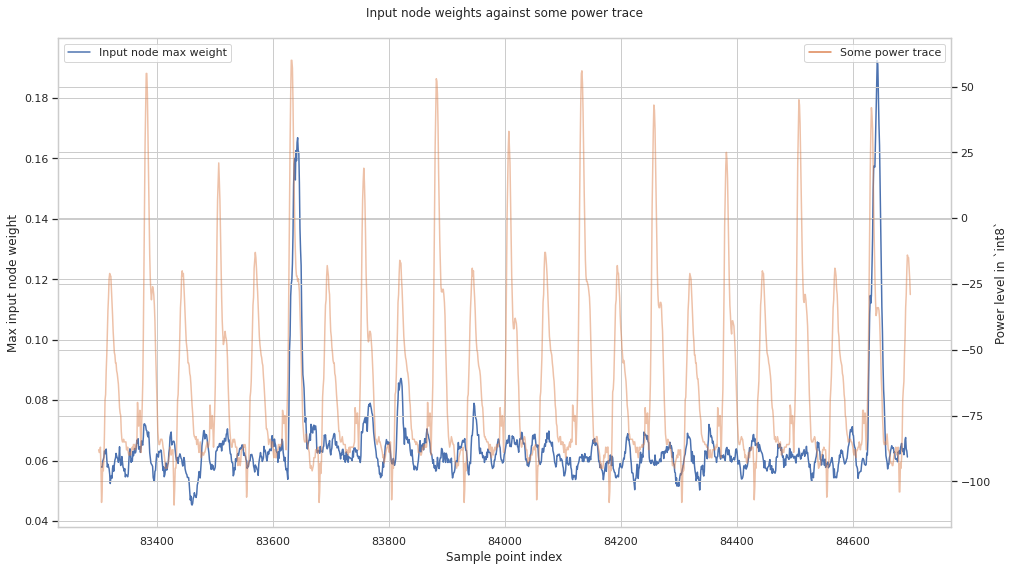

In [18]:
plot_input_weight(SLIDING_RES, 119)